In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/통계데이터사이언스/lending_club/preprocessed_data_ver.2.3._IRR+LOG+BINARY.csv')

In [ ]:
# 모든 열 다 보기
pd.set_option('display.max_columns', None)

# 모든 행 다 보기
pd.set_option('display.max_rows', None)

# 열 너비 넉넉하게
pd.set_option('display.width', None)

# 열 안의 값 자르지 않게
pd.set_option('display.max_colwidth', None)

In [ ]:
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,delinq_amnt_missing,annual_inc_missing,open_act_il_missing,mths_since_recent_inq_missing,collection_recovery_fee_missing,mths_since_rcnt_il_missing,revol_bal_missing,open_il_12m_missing,all_util_missing,fico_range_low_missing,open_acc_6m_missing,delinq_2yrs_missing,open_acc_missing,total_acc_missing,inq_last_12m_missing,funded_amnt_missing,installment_missing,open_il_24m_missing,open_rv_24m_missing,inq_last_6mths_missing,open_rv_12m_missing,acc_now_delinq_missing,last_fico_range_high_missing,pub_rec_missing,total_bal_il_missing,recoveries_missing,max_bal_bc_missing,il_util_missing,mths_since_last_delinq_missing,fico_range_high_missing,mths_since_recent_revol_delinq_missing
0,6000.0,36,187.94,2.0,10.714440,2017-12-01,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,23200.0,60,680.82,10.0,11.608245,2016-07-01,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,55.9,60.0,5260.00,946.800,Dec-2016,639.0,0,0,0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,8.455105,85.0,10.317450,7.0,8.0,10.137175,8.702012,70.4,0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,0.0,10.0,0.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0,0,0,5.0,94.8,37.5,0,0,13.386134,12.592905,9.918425,12.582679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# 독립변수에서 제외할 변수 목록
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default', 'issue_d'
]

X = df.drop(columns=drop_cols)
y = df['default']

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred

# FRED API 연결
fred = Fred(api_key="05ceea53cbc890aa3e4416729c89001b")  # 실제 API 키로 대체해야 함

# 미국 3년 만기 국채 수익률(GS3) 시계열 불러오기
series = fred.get_series('GS3')  # pandas.Series 형식으로 반환됨


print(series.head())

1953-04-01    2.51
1953-05-01    2.72
1953-06-01    2.74
1953-07-01    2.62
1953-08-01    2.58
dtype: float64


In [ ]:
def get_nearest_rate(issue_date, rate_series):
    if pd.isnull(issue_date):
        return np.nan
    try:
        idx = rate_series.index.get_indexer([issue_date], method='nearest')[0]
        return rate_series.iloc[idx] / 100  # % 단위 → 소수로 변환
    except Exception as e:
        print(f"Error: {issue_date} ▶ {e}")
        return np.nan


df['risk_free_rate'] = df['issue_d'].apply(lambda x: get_nearest_rate(x, series))


In [ ]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['issue_d'] = pd.to_datetime(df['issue_d'])  # 혹시 모르니 이것도

/tmp/ipython-input-4242469769.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])


In [ ]:
print(df[['issue_d', 'risk_free_rate', 'last_pymnt_d']].head())

     issue_d  risk_free_rate last_pymnt_d
0 2017-12-01          0.0196   2020-04-01
1 2016-07-01          0.0079   2016-12-01
2 2017-10-01          0.0168   2019-08-01
3 2017-05-01          0.0148   2019-03-01
4 2015-09-01          0.0101   2018-10-01


In [ ]:
from dateutil.relativedelta import relativedelta

def create_cash_flow_from_dates(row):
    try:
        term = int(row['term'])
        default = int(row['default'])
        issue_d = row['issue_d']  # 이미 datetime 형식
        last_pymnt_d = pd.to_datetime(row['last_pymnt_d'])  # 이건 문자열일 수도 있으니 변환
        installment = float(row['installment'])
        funded_amnt = float(row['funded_amnt'])
        recoveries = float(row['recoveries'])
        collection_fee = float(row['collection_recovery_fee'])

        # 첫 현금흐름: 대출 실행
        cash_flow = [-funded_amnt]

        if pd.isnull(issue_d) or pd.isnull(last_pymnt_d):
            return np.nan

        # 몇 회차까지 납입했는지 계산
        delta = relativedelta(last_pymnt_d, issue_d)
        last_pymnt_num = delta.years * 12 + delta.months

        for month in range(1, term + 1):
            if default == 1:
                if month <= last_pymnt_num:
                    cash_flow.append(installment)
                elif month == last_pymnt_num + 1:
                    cash_flow.append(recoveries - collection_fee)
                else:
                    cash_flow.append(0)
            else:
                cash_flow.append(installment)

        return cash_flow

    except Exception as e:
        print(f"[오류] index={row.name}, error={e}")
        return np.nan


In [ ]:
df['cash_flow'] = df.apply(create_cash_flow_from_dates, axis=1)

In [ ]:
!pip install numpy-financial

In [ ]:
import numpy_financial as npf

def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is None or np.isnan(irr_monthly):
        return np.nan
    return (1 + irr_monthly) ** 12 - 1  # 연환산

In [ ]:
df['irr'] = df['cash_flow'].apply(get_irr)

In [ ]:
df['irr'] = df['irr'].fillna(df['risk_free_rate'])

In [5]:
# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []


# Sharpe 계산 함수
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import json
import os

# 저장 경로 설정
SAVE_DIR = "/content/drive/MyDrive/통계데이터사이언스/lending_club"
os.makedirs(SAVE_DIR, exist_ok=True)


# 랜덤포레스트 하이퍼파라미터 범위 지정
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 전체 데이터의 일부만 샘플링하여 튜닝 데이터 구성
X_tune_full, _, y_tune_full, _ = train_test_split(X, y, test_size=0.2, stratify=y)
X_tune, _, y_tune, _ = train_test_split(
    X_tune_full, y_tune_full,
    train_size=50000,  # 샘플 수 조절 가능
    stratify=y_tune_full,
    random_state=42
)

# RandomizedSearchCV 수행
model_base = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    model_base,
    param_distributions=param_dist,
    n_iter=5,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1,
    verbose=2
)
search.fit(X_tune, y_tune)

# 최적 하이퍼파라미터 출력
best_params = search.best_params_
print("✅ Best hyperparameters (from tuning):", best_params)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ Best hyperparameters (from tuning): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [ ]:
best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'n_jobs': -1,
}


In [ ]:
# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []

# 베스트 모델 저장 변수
best_model = None
best_sharpe_overall = -np.inf
best_model_index = None
best_threshold_overall = None
best_params_overall = None

# best_params는 미리 정의되어 있다고 가정
# 예: best_params = {...}

for i in tqdm(range(100)):
    # 매 반복마다 다른 seed 사용
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=i, stratify=y_temp
    )

    # 모델 학습
    model = RandomForestClassifier(**best_params, random_state=i)
    model.fit(X_train, y_train)

    # 검증셋 예측 확률
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.05)

    best_sharpe = -np.inf
    best_threshold = None
    df_val = df.loc[X_val.index]

    for threshold in thresholds:
        approved_mask = y_pred_proba <= threshold
        denied_mask = ~approved_mask

        selected = df_val.copy()
        selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
        selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

        returns = selected['irr_adj']
        risk_free = selected['risk_free_rate']
        valid = returns.notnull() & risk_free.notnull()

        if valid.sum() < 2:
            continue

        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = threshold

    best_models.append(model)
    best_thresholds.append(best_threshold)
    validation_sharpes.append(best_sharpe)

    # 테스트셋 평가
    y_test_proba = model.predict_proba(X_test)[:, 1]
    test_approved_mask = y_test_proba <= best_threshold
    df_test = df.loc[X_test.index]
    test_selected = df_test[test_approved_mask]

    returns_test = test_selected['irr']
    risk_free_test = test_selected['risk_free_rate']
    valid = returns_test.notnull() & risk_free_test.notnull()
    returns_test = returns_test[valid]
    risk_free_test = risk_free_test[valid]

    sharpe_test = calculate_sharpe(returns_test, risk_free_test)
    test_sharpes.append(sharpe_test)
    test_approval_rates.append(len(returns_test) / len(df_test))
    test_irr_means.append(returns_test.mean())
    test_irr_positive_rates.append((returns_test > 0).mean())

    # Best 모델 업데이트
    if sharpe_test > best_sharpe_overall:
        best_sharpe_overall = sharpe_test
        best_model = model
        best_model_index = i
        best_threshold_overall = best_threshold
        best_params_overall = model.get_params()

# Best 모델 저장
joblib.dump(best_model, f"{SAVE_DIR}/best_model2.pkl")
with open(f"{SAVE_DIR}/best_model_threshold2.json", "w") as f:
    json.dump({"threshold": best_threshold_overall}, f)
with open(f"{SAVE_DIR}/best_model_params2.json", "w") as f:
    json.dump(best_params_overall, f)

# 최종 결과 출력
print("\n최종 결과 요약")
print("✅ Best model index:", best_model_index)
print("✅ Best validation Sharpe ratio:", validation_sharpes[best_model_index])
print("✅ Best test Sharpe ratio:", test_sharpes[best_model_index])
print("✅ Best approval rate:", test_approval_rates[best_model_index])
print("✅ Mean IRR:", test_irr_means[best_model_index])
print("✅ Positive IRR ratio:", test_irr_positive_rates[best_model_index])
print("✅ Best threshold:", best_thresholds[best_model_index])
print("✅ Best model params:", best_model.get_params())


100%|██████████| 100/100 [1:57:28<00:00, 70.48s/it]


최종 결과 요약
✅ Best model index: 23
✅ Best validation Sharpe ratio: 0.5570060701651625
✅ Best test Sharpe ratio: 0.7698286175096084
✅ Best approval rate: 0.6473623853211009
✅ Mean IRR: 0.11128391015454252
✅ Positive IRR ratio: 0.9782094220549159
✅ Best threshold: 0.15000000000000002
✅ Best model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 23, 'verbose': 0, 'warm_start': False}


In [ ]:
print("Best thresholds from 100 runs:")
print(best_thresholds)

print("\nValidation Sharpe Ratios from 100 runs:")
print(validation_sharpes)

print("\nTest Sharpe Ratios from 100 runs:")
print(test_sharpes)

print("\nTest Approval Rates:")
print(test_approval_rates)

print("\nTest IRR Means:")
print(test_irr_means)

print("\nTest IRR Positive Rates:")
print(test_irr_positive_rates)


Best thresholds from 100 runs:
[np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(0.15000000000000002), np.float64(

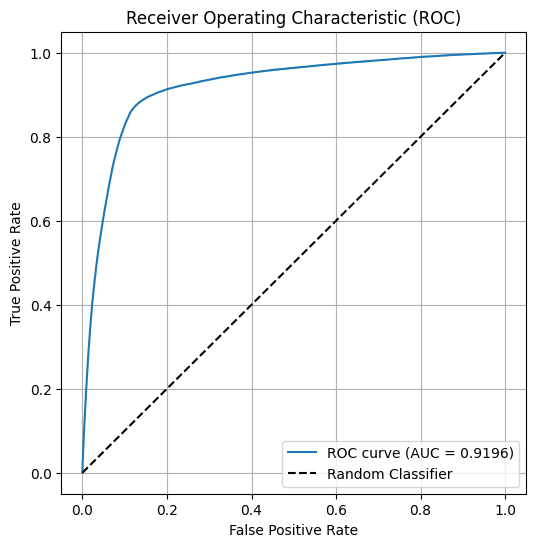

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예: test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


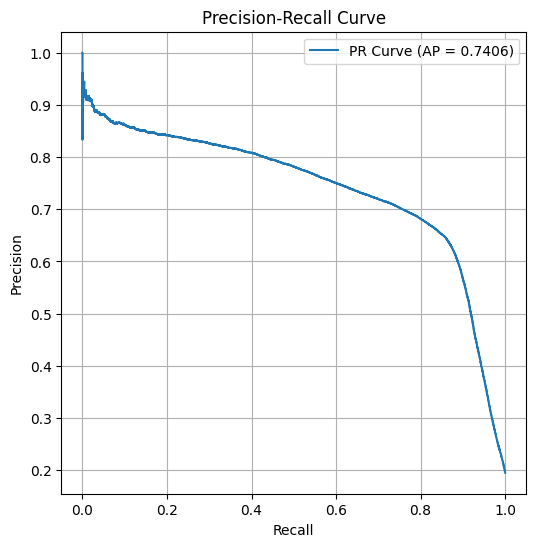

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


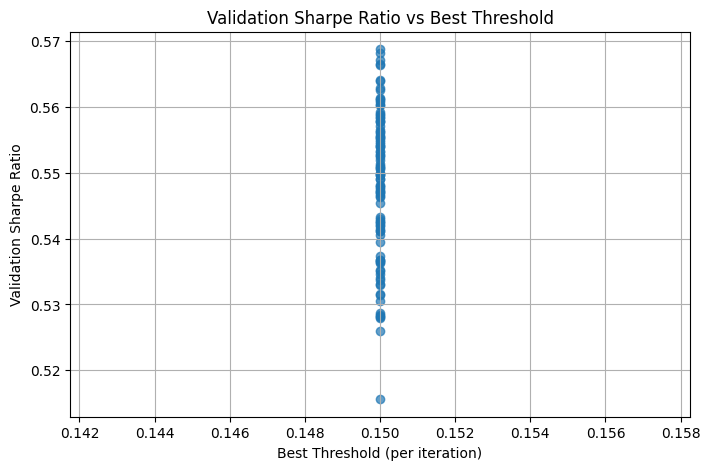

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(best_thresholds, validation_sharpes, alpha=0.7)
plt.title("Validation Sharpe Ratio vs Best Threshold")
plt.xlabel("Best Threshold (per iteration)")
plt.ylabel("Validation Sharpe Ratio")
plt.grid(True)
plt.show()


In [ ]:
thresholds = np.arange(0.0, 1.0, 0.05)
sharpe_by_threshold = []

# df_val은 X_val의 인덱스를 기반으로 만듦
df_val = df.loc[X_val.index]
y_pred_proba = model.predict_proba(X_val)[:, 1]

for threshold in thresholds:
    approved_mask = y_pred_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']
    valid = returns.notnull() & risk_free.notnull()

    if valid.sum() < 2:
        sharpe = np.nan
    else:
        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

    sharpe_by_threshold.append(sharpe)


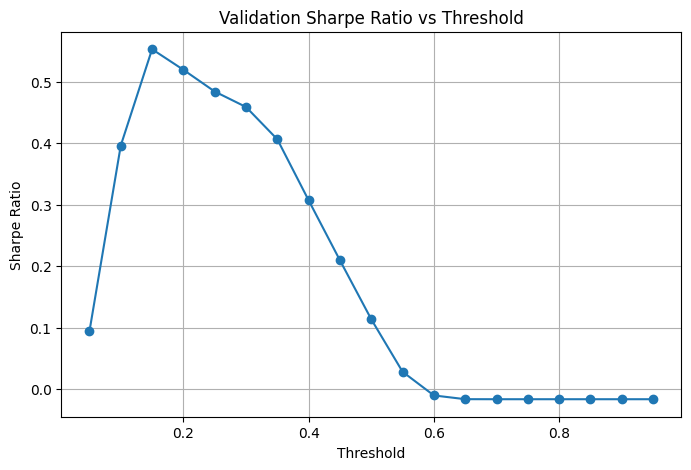

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.05)
sharpe_by_threshold = []

# 예시: 마지막 반복의 model, X_val, y_val 사용
y_val_proba = model.predict_proba(X_val)[:, 1]
df_val = df.loc[X_val.index]

for threshold in thresholds:
    approved_mask = y_val_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']
    valid = returns.notnull() & risk_free.notnull()

    if valid.sum() < 2:
        sharpe = np.nan
    else:
        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

    sharpe_by_threshold.append(sharpe)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(thresholds, sharpe_by_threshold, marker='o')
plt.title("Validation Sharpe Ratio vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()


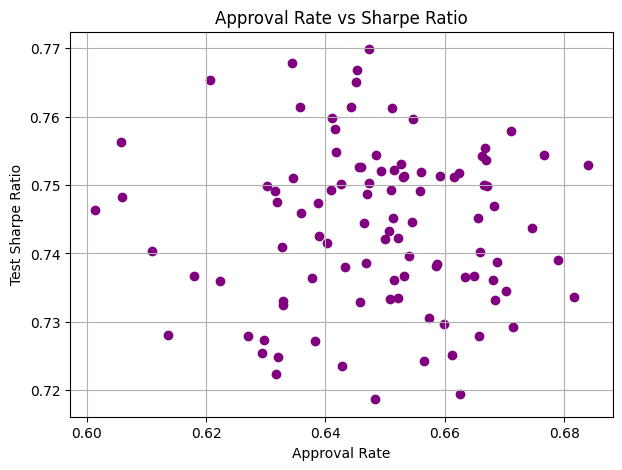

In [ ]:
# IRR 평균 및 Positive 비율 비교
plt.figure(figsize=(7, 5))
plt.scatter(test_approval_rates, test_sharpes, color='purple')
plt.title("Approval Rate vs Sharpe Ratio")
plt.xlabel("Approval Rate")
plt.ylabel("Test Sharpe Ratio")
plt.grid(True)
plt.show()

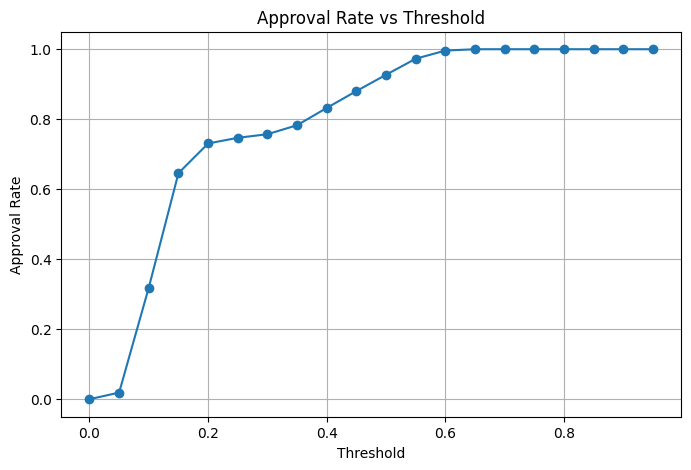

In [ ]:
approval_rates = []

for threshold in thresholds:
    approved = (y_val_proba <= threshold).sum()
    approval_rate = approved / len(y_val_proba)
    approval_rates.append(approval_rate)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, approval_rates, marker='o')
plt.title("Approval Rate vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Approval Rate")
plt.grid(True)
plt.show()


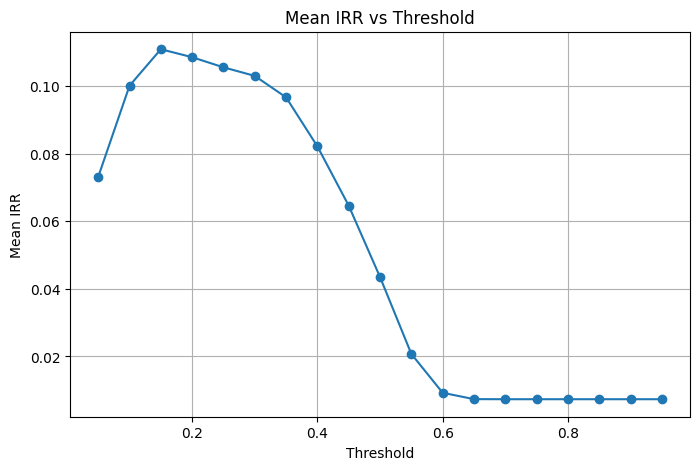

In [ ]:
irr_means = []

for threshold in thresholds:
    approved_mask = y_val_proba <= threshold
    selected = df_val[approved_mask]
    irr_mean = selected['irr'].dropna().mean()
    irr_means.append(irr_mean)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, irr_means, marker='o')
plt.title("Mean IRR vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Mean IRR")
plt.grid(True)
plt.show()


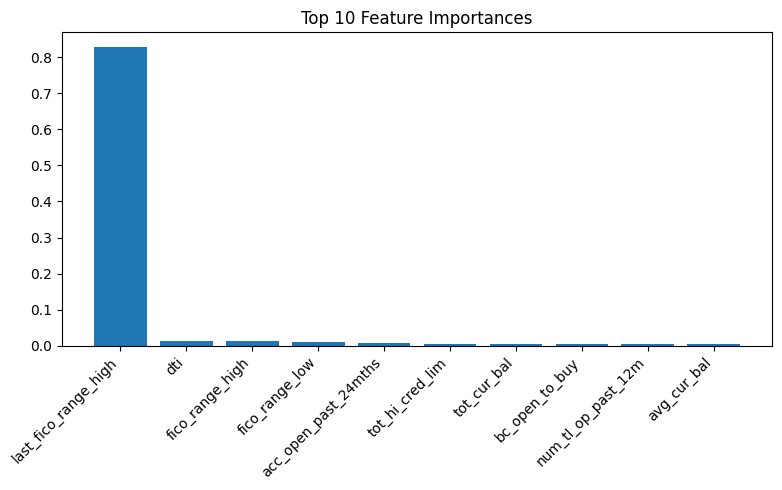

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  # 상위 10개

plt.figure(figsize=(8, 5))
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=45, ha='right')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import joblib
best_model = joblib.load('/content/drive/MyDrive/통계데이터사이언스/lending_club/best_model2.pkl')

In [8]:
from joblib import load
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('https://snu-bigdata-fintech-ai.s3.ap-northeast-2.amazonaws.com/data/test/preprocessing_lending_club_2020_test.csv', low_memory=True)
df['inq_last_6mths_missing'] = df['inq_last_6mths'].isnull().astype(int)

# 저장된 모델 경로로 수정
best_model = load('/content/drive/MyDrive/통계데이터사이언스/lending_club/best_model2.pkl')
best_threshold = 0.15

# feature 이름 추출 후 데이터 구성
X_test = df[best_model.feature_names_in_].copy()

# 이상치 및 결측 처리
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)

# Test 데이터 준비
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # 양성 클래스 확률
approved_mask = y_test_proba <= best_threshold         # threshold 기준 승인 여부
df_test_selected = df.loc[X_test.index].copy()         # 테스트 샘플 원본

# 승인된 대출에는 irr, 거부된 대출은 risk_free_rate 적용
df_test_selected['irr_adj'] = df_test_selected['risk_free_rate']  # 기본값 설정
df_test_selected.loc[approved_mask, 'irr_adj'] = df_test_selected.loc[approved_mask, 'irr']

# Sharpe ratio 계산
returns = df_test_selected['irr_adj']
risk_free = df_test_selected['risk_free_rate']
valid = returns.notnull() & risk_free.notnull()

sharpe_final = calculate_sharpe(returns[valid], risk_free[valid])
approval_rate_final = approved_mask.sum() / len(approved_mask)
mean_irr = returns[valid].mean()
positive_rate = (returns[valid] > 0).mean()

# 결과 출력
print("Final Test Prediction Summary")
print("✅ Sharpe Ratio:", sharpe_final)
print("✅ Approval Rate:", approval_rate_final)
print("✅ Mean IRR:", mean_irr)
print("✅ Positive IRR Ratio:", positive_rate)

# 필요시 승인된 대출 정보 출력
approved_loans = df_test_selected[approved_mask]

Final Test Prediction Summary
✅ Sharpe Ratio: 0.5490419284395721
✅ Approval Rate: 0.6538473935278697
✅ Mean IRR: 0.07650484042990204
✅ Positive IRR Ratio: 0.9851720636898879
